    Generate figures to help understand the calibration document

In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

dirName = "/Users/mfisherlevine/Desktop/CBP_talk_plots"

/Users/mfisherlevine/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# pixel coordinates
ib = np.linspace(-1, 1, 500)
# additive part of flat field screen illumination
i = 0.05*ib**2
# true per-pixel sensitivity variation (assuming all pixels are the same size)
nPerCCD = len(ib)//4      # we have 4 chips in the following S_qe prescription
S_qe = 0.98*np.where(ib < -0.5,         0.90 - 0.1*(ib + 0.5), 
                     np.where(ib < 0,   0.95 + 0.05*ib,
                     np.where(ib < 0.5, 0.85 - 0.1*(ib - 0.5), 
                                        0.87 + 0.05*ib)))
# additive term
A = -0.05*np.cos(2*ib*np.pi)
# optical distortion
S_optical = 1 - 0.1*ib**4
S_ccd = 1 + 0.01*np.sin(10*ib*np.pi)
# sensitivity allowing for pixel size variation
calS = S_qe*S_optical*S_ccd
# measured flat field
Fb = (1 + i + A)*calS

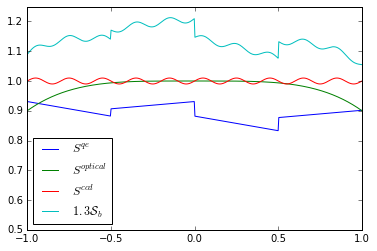

In [3]:
plt.plot(ib, S_qe, label='$S^{qe}$')
plt.plot(ib, S_optical, label='$S^{optical}$')
plt.plot(ib, S_ccd, label='$S^{ccd}$')

scale=1.3
plt.plot(ib, scale*calS, label='$%g{\cal S}_b$' % scale)

plt.legend(loc='best').draggable()
foo = plt.ylim(0.5, 1.25)

plt.savefig(os.path.join(dirName, "S.pdf"))

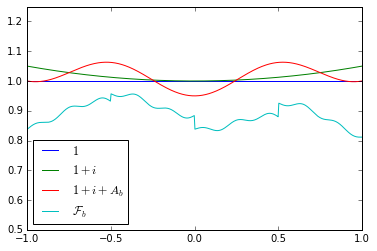

In [4]:
plt.plot(ib, np.ones_like(ib), label='$1$')
plt.plot(ib, 1 + i, label='$1 + i$')
plt.plot(ib, 1 + i + A, label='$1 + i + A_b$')
if False:
    scale = 1.3
    plt.plot(ib, scale*calS, label='$%g{\cal S}_b$' % scale)

plt.plot(ib, Fb, label='${\cal F}_b$')
plt.legend(loc='best').draggable()
foo = plt.ylim(0.5, 1.25)

plt.savefig(os.path.join(dirName, "F_b.pdf"))

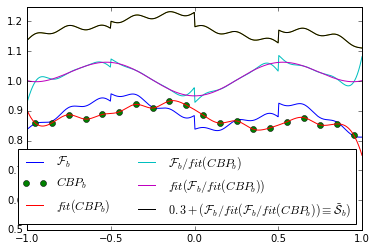

In [5]:
from scipy import interpolate

nSampleCBP = 5            # number of CBP spots per chip
samples = (np.arange(len(ib))%nPerCCD)%(nPerCCD//nSampleCBP) == (nPerCCD//nSampleCBP)//2  # Where we take CBP data

interpCalS = interpolate.InterpolatedUnivariateSpline(ib[samples], calS[samples])  # spline fit to CBP data
#
# Estimate the illumination from the interpolated CBP data
rawEstIllum = Fb/interpCalS(ib)   # raw estimated illumination
# And fit it with a smoothing spline
interpIllum = interpolate.UnivariateSpline(ib[samples], rawEstIllum[samples], s=1e-8)
# and use that to estimate the true calS
estCalS = Fb/interpIllum(ib)

plt.plot(ib, Fb, label='${\cal F}_b$')

plt.plot(ib[samples], calS[samples], 'o', label=r'$CBP_b$')
plt.plot(ib, interpCalS(ib), label=r'$fit(CBP_b)$')

plt.plot(ib, rawEstIllum, label='${\cal F}_b/fit(CBP_b)$')
plt.plot(ib, interpIllum(ib), label='$fit({\cal F}_b/fit(CBP_b))$')

plt.plot(ib, calS + 0.3)
plt.plot(ib, estCalS + 0.3, label=r'$0.3 + ({\cal F}_b/fit({\cal F}_b/fit(CBP_b)) \equiv \tilde{\cal S}_b)$')

plt.legend(loc='best', ncol=2)
foo = plt.ylim(0.5, 1.25)

plt.savefig(os.path.join(dirName, "CBP.pdf"))

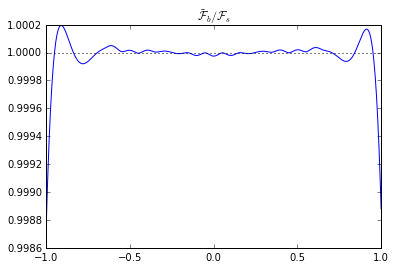

In [6]:
plt.plot(ib, estCalS/calS)
plt.axhline(1.0, color='k', ls=':')
_ = plt.title(r'$\tilde{\cal F}_b/{\cal F}_s$')

plt.savefig(os.path.join(dirName, "CBP-errors.pdf"))